# BoomBikes Case Study Multiple Linear Regression
##### 1. The company wants to identify the factors which are affecting the demands of this shared bikes.
##### 2. So here we will be keeping "totalcount" as our target variable and where there are other predictor variables which will help in building the    model.
##### 3. We will check the accuracy of the model and try to predict the totalcount.

## Step 1: Reading and Understanding the Data
Lets first import required libraries and read the data.

In [1]:
import numpy as np,pandas as pd

# For visualising the data.
import matplotlib.pyplot as plt
import seaborn as sns

# For statistical modelling.
import sklearn
from sklearn.model_selection import train_test_split    # For splitting the data into train and test data
from sklearn.preprocessing import MinMaxScaler          # For rescaling purpose
from sklearn.metrics import r2_score   

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor    # To compute the VIF values of all the features.

# For Supressing warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Read the given CSV file, and view some sample records
boombikes = pd.read_csv("day.csv")
boombikes.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,1,0,1,0,1,1,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,1,0,1,0,2,1,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,1,0,1,0,3,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,1,0,1,0,4,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,1,0,1,0,5,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


In [3]:
# Changing the name of variables to appropriate names so its descriptive
boombikes.rename(columns = {'dteday':'date', 'yr':'year','mnth':'month',
                              'hum':'humidity','atemp':'feeltemp','cnt':'totalcount'}, inplace = True)

In [4]:
boombikes.shape

(730, 16)

In [5]:
# dropping the columns ["instant",""date","casual","registered"] 
boombikes = boombikes.drop(['instant','date','casual','registered'],axis=1)

# instant - it is just an index number which is of no use to us.
# date - we already have year-month-weekday so we dont need the date feature.
# casual,registered is just summed up to make a totalcount feature so that is also not needed.

In [6]:
boombikes.head()

,season,year,month,holiday,weekday,workingday,weathersit,temp,feeltemp,humidity,windspeed,totalcount
0,1,0,1,0,1,1,2,14.110847,18.18125,80.5833,10.749882,985
1,1,0,1,0,2,1,2,14.902598,17.68695,69.6087,16.652113,801
2,1,0,1,0,3,1,1,8.050924,9.47025,43.7273,16.636703,1349
3,1,0,1,0,4,1,1,8.200000,10.60610,59.0435,10.739832,1562
4,1,0,1,0,5,1,1,9.305237,11.46350,43.6957,12.522300,1600


In [7]:
boombikes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   season      730 non-null    int64  
 1   year        730 non-null    int64  
 2   month       730 non-null    int64  
 3   holiday     730 non-null    int64  
 4   weekday     730 non-null    int64  
 5   workingday  730 non-null    int64  
 6   weathersit  730 non-null    int64  
 7   temp        730 non-null    float64
 8   feeltemp    730 non-null    float64
 9   humidity    730 non-null    float64
 10  windspeed   730 non-null    float64
 11  totalcount  730 non-null    int64  
dtypes: float64(4), int64(8)
memory usage: 68.6 KB


In [8]:
# There are no null values present so we dont need to impute anything and also the datatypes are correct.

In [9]:
# Mapping feature values into string values.
boombikes.season = boombikes.season.replace({1:'spring',2:'summer',3:'fall',4:'winter'})
boombikes.month = boombikes.month.replace({1:'jan',2:'feb',3:'mar',4:'apr',5:'may',6:'june',7:'july',8:'aug',9:'sep',10:'oct',11:'nov',12:'dec'})
boombikes.weekday = boombikes.weekday.replace({0:'sunday',1:'monday',2:'tuesday',3:'wednesday',4:'thursday',5:'friday',6:'saturday'})
boombikes.weathersit = boombikes.weathersit.replace({1:'Clear',2:'Mist + Cloudy',3:'Light Snow',4:'Snow + Fog'})

In [10]:
boombikes.head()

,season,year,month,holiday,weekday,workingday,weathersit,temp,feeltemp,humidity,windspeed,totalcount
0,spring,0,jan,0,monday,1,Mist + Cloudy,14.110847,18.18125,80.5833,10.749882,985
1,spring,0,jan,0,tuesday,1,Mist + Cloudy,14.902598,17.68695,69.6087,16.652113,801
2,spring,0,jan,0,wednesday,1,Clear,8.050924,9.47025,43.7273,16.636703,1349
3,spring,0,jan,0,thursday,1,Clear,8.200000,10.60610,59.0435,10.739832,1562
4,spring,0,jan,0,friday,1,Clear,9.305237,11.46350,43.6957,12.522300,1600


In [11]:
# Lets check if temp and feeltemp,humidity,windspeed,totalcount have some correlation
boombikes[['temp','feeltemp','humidity','windspeed','totalcount']].corr()

,temp,feeltemp,humidity,windspeed,totalcount
temp,1.000000,0.991696,0.128565,-0.158186,0.627044
feeltemp,0.991696,1.000000,0.141512,-0.183876,0.630685
humidity,0.128565,0.141512,1.000000,-0.248506,-0.098543
windspeed,-0.158186,-0.183876,-0.248506,1.000000,-0.235132
totalcount,0.627044,0.630685,-0.098543,-0.235132,1.000000


In [12]:
# felltemp is actually how hot is feels which depends on actual temperature,windspeed and humidity.
# since there is high correlation  between temp and feeltemp so any one of it can be dropped.
# we will drop feeltemp in this case as it has slight relation with windspeed and humidity and in future will not be facing any issue so its better we go ahead with temp.

In [13]:
boombikes = boombikes.drop(['feeltemp'],axis=1)

In [14]:
boombikes.head()

,season,year,month,holiday,weekday,workingday,weathersit,temp,humidity,windspeed,totalcount
0,spring,0,jan,0,monday,1,Mist + Cloudy,14.110847,80.5833,10.749882,985
1,spring,0,jan,0,tuesday,1,Mist + Cloudy,14.902598,69.6087,16.652113,801
2,spring,0,jan,0,wednesday,1,Clear,8.050924,43.7273,16.636703,1349
3,spring,0,jan,0,thursday,1,Clear,8.200000,59.0435,10.739832,1562
4,spring,0,jan,0,friday,1,Clear,9.305237,43.6957,12.522300,1600


In [15]:
boombikes.describe()

,year,holiday,workingday,temp,humidity,windspeed,totalcount
count,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000
mean,0.500000,0.028767,0.690411,20.319259,62.765175,12.763620,4508.006849
std,0.500343,0.167266,0.462641,7.506729,14.237589,5.195841,1936.011647
min,0.000000,0.000000,0.000000,2.424346,0.000000,1.500244,22.000000
25%,0.000000,0.000000,0.000000,13.811885,52.000000,9.041650,3169.750000
50%,0.500000,0.000000,1.000000,20.465826,62.625000,12.125325,4548.500000
75%,1.000000,0.000000,1.000000,26.880615,72.989575,15.625589,5966.000000
max,1.000000,1.000000,1.000000,35.328347,97.250000,34.000021,8714.000000


# Step 2: Visualising the data
Let's now spend some time doing what is arguably the most important step - **understanding the data**.
- If there is some obvious multicollinearity going on, this is the first place to catch it
- Here's where you'll also identify if some predictors directly have a strong association with the outcome variable .

## Visualising numeric variables.

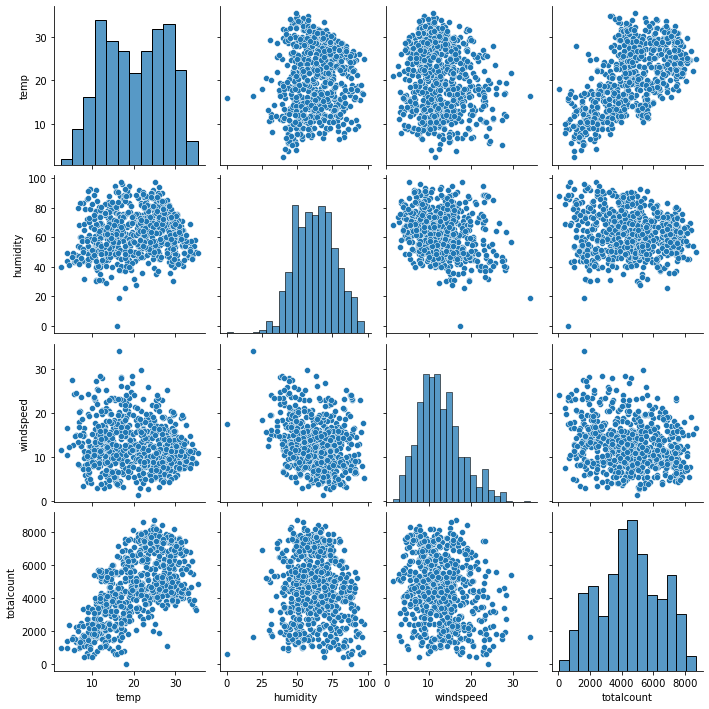

In [16]:
sns.pairplot(boombikes[['temp','humidity','windspeed','totalcount']])
plt.show()

## Visualising categorical variables

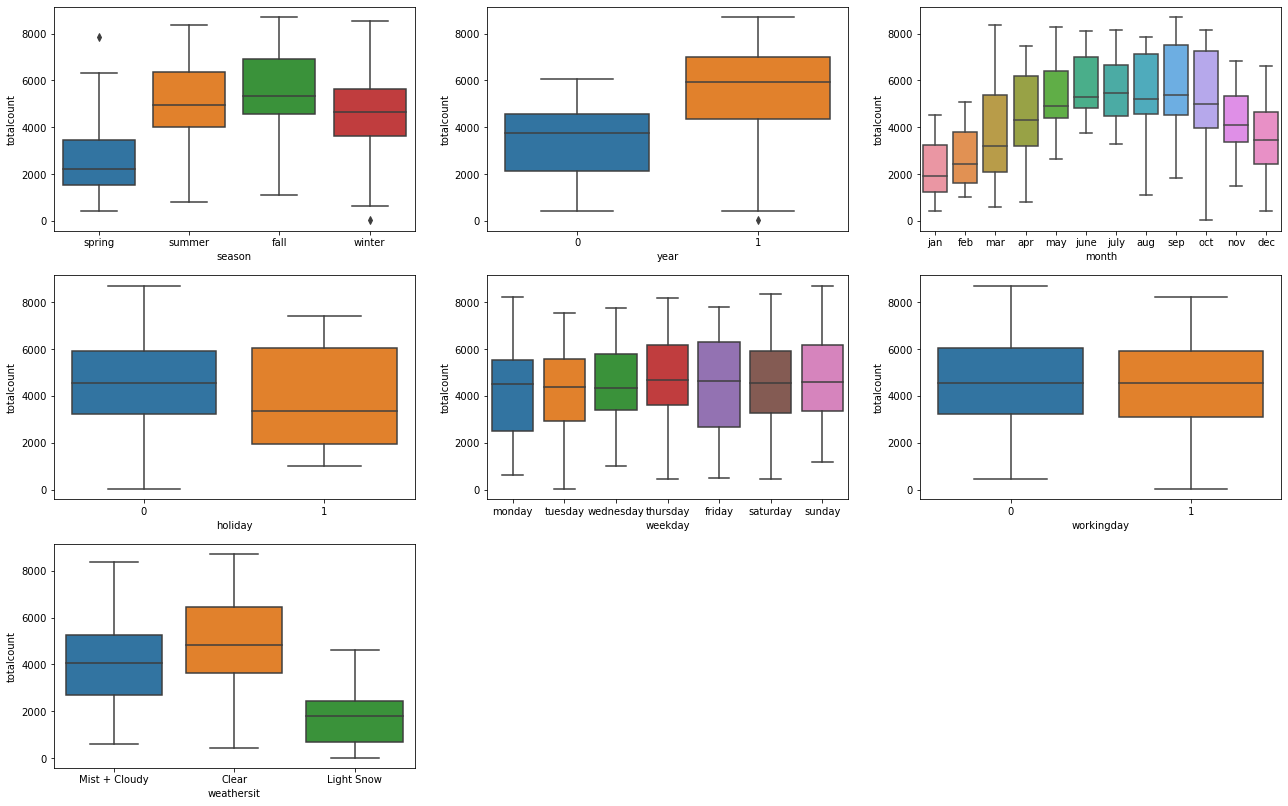

In [17]:
# lets make a boxplot and check all those categorical variables.
plt.figure(figsize=(22,14))
plt.subplot(3,3,1)
sns.boxplot(data=boombikes,x = "season",y="totalcount")
plt.subplot(3,3,2)
sns.boxplot(data=boombikes,x = "year",y="totalcount")
plt.subplot(3,3,3)
sns.boxplot(data=boombikes,x = "month",y="totalcount")
plt.subplot(3,3,4)
sns.boxplot(data=boombikes,x = "holiday",y="totalcount")
plt.subplot(3,3,5)
sns.boxplot(data=boombikes,x = "weekday",y="totalcount")
plt.subplot(3,3,6)
sns.boxplot(data=boombikes,x = "workingday",y="totalcount")
plt.subplot(3,3,7)
sns.boxplot(data=boombikes,x = "weathersit",y="totalcount")
plt.show()

##### Inferences from above boxplots
- From season plot we can see that fall has the highest demand for boombikes and 2019 was the year with highest count.
- Monthwise also there is increase from may till september which is basically a summer season and then decreasing this means in general summer season has a high demand in USA.
- Holidays show lower demand as compared to when its not holiday.
- There is so such significant difference in weekdays demands and also on working days.
- Clear weather shows highest demand in bikes which justifies that its easy to drive during clear weather.

In [18]:
boombikes.weathersit.value_counts()
# You can see that there is no data for 4th category of weather i.e. "Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog"

Clear            463
Mist + Cloudy    246
Light Snow        21
Name: weathersit, dtype: int64

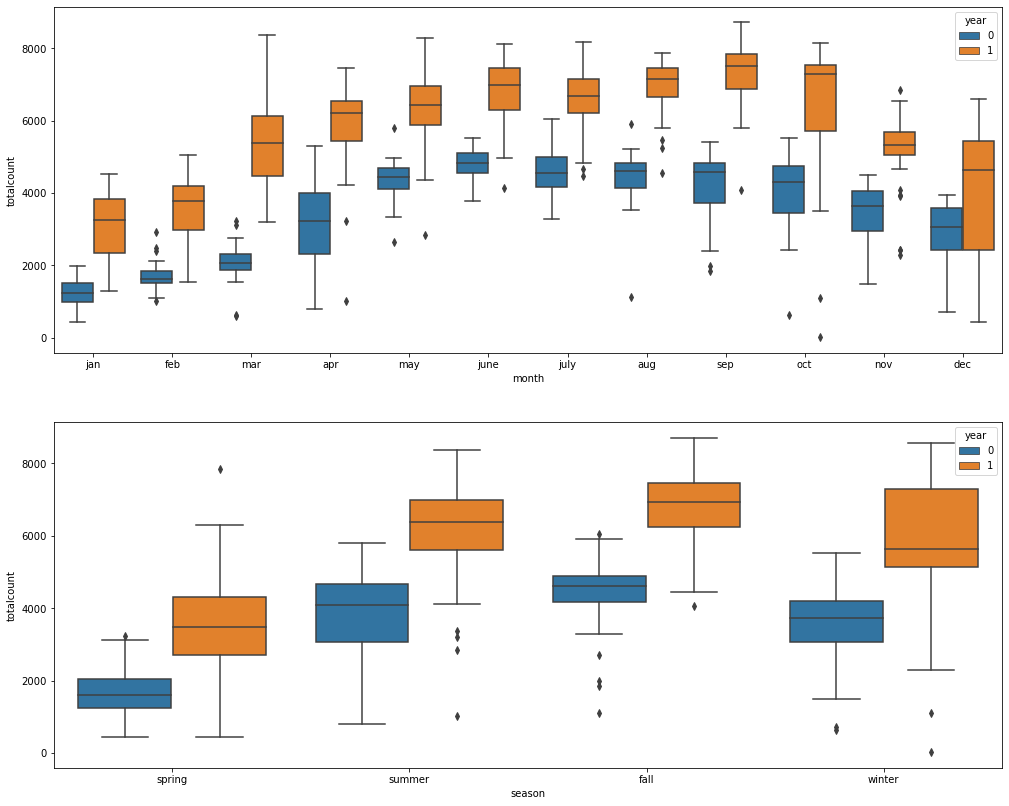

In [19]:
# We can check the monthly demand with different years and seasons, we can use "hue" here to plot so we will know data for each year and month simultaneously.
plt.figure(figsize=(17,14))
plt.subplot(2,1,1)
sns.boxplot(data=boombikes,x="month",y="totalcount",hue="year")
plt.subplot(2,1,2)
sns.boxplot(data=boombikes,x="season",y="totalcount",hue="year")
plt.show()

##### We can see that year 2019 had more demands then comapred to 2018 with regards to monthwise and seasonwise as well.

## Step 3: Data Preparation


### Dummy variables
- Getting dummy variables for the feature  and storing it in a new variables and then adding those variables back to dataset.

In [20]:
# creating dummy variables and dropping first columns of those dummy variables.
season_dummy = pd.get_dummies(boombikes['season'],drop_first=True)
month_dummy = pd.get_dummies(boombikes['month'],drop_first=True)
year_dummy = pd.get_dummies(boombikes['weekday'],drop_first=True)
weathersit_dummy = pd.get_dummies(boombikes['weathersit'],drop_first=True)

In [21]:
# Adding those dummy variables back to dataset
boombikes = pd.concat([boombikes,season_dummy,month_dummy,year_dummy,weathersit_dummy],axis=1)

In [22]:
# lets check columns of dataframe
boombikes.columns

Index(['season', 'year', 'month', 'holiday', 'weekday', 'workingday',
       'weathersit', 'temp', 'humidity', 'windspeed', 'totalcount', 'spring',
       'summer', 'winter', 'aug', 'dec', 'feb', 'jan', 'july', 'june', 'mar',
       'may', 'nov', 'oct', 'sep', 'monday', 'saturday', 'sunday', 'thursday',
       'tuesday', 'wednesday', 'Light Snow', 'Mist + Cloudy'],
      dtype='object')

In [23]:
# dropping the respective main columns as we now have dummy variables now.
boombikes = boombikes.drop(columns=['season','month','weekday','weathersit'])

In [24]:
boombikes.head()

,year,holiday,workingday,temp,humidity,windspeed,totalcount,spring,summer,winter,...,oct,sep,monday,saturday,sunday,thursday,tuesday,wednesday,Light Snow,Mist + Cloudy
0,0,0,1,14.110847,80.5833,10.749882,985,1,0,0,...,0,0,1,0,0,0,0,0,0,1
1,0,0,1,14.902598,69.6087,16.652113,801,1,0,0,...,0,0,0,0,0,0,1,0,0,1
2,0,0,1,8.050924,43.7273,16.636703,1349,1,0,0,...,0,0,0,0,0,0,0,1,0,0
3,0,0,1,8.200000,59.0435,10.739832,1562,1,0,0,...,0,0,0,0,0,1,0,0,0,0
4,0,0,1,9.305237,43.6957,12.522300,1600,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [25]:
# lets checkthe shape of the dataframe
boombikes.shape

(730, 29)

## Step 4: Splitting the Data into Training and Testing Sets

As you know, the first basic step for regression is performing a train-test split.

In [26]:
boombk_train,boombk_test = train_test_split(boombikes,train_size=0.7,random_state=100)

In [27]:
print(boombk_train.shape)
print(boombk_test.shape)

(510, 29)
(220, 29)


### Rescaling the features

As you saw in the demonstration for Simple Linear Regression, scaling doesn't impact your model. Here we can see that all the columns have small integer values. So it is extremely important to rescale the variables so that they have a comparable scale. If we don't have comparable scales, then some of the coefficients as obtained by fitting the regression model might be very large or very small as compared to the other coefficients. This might become very annoying at the time of model evaluation. So it is advised to use standardization or normalization so that the units of the coefficients obtained are all on the same scale.
There are 2 ways of rescaling:
1. Min-Max scaling (all values lies between 0 and 1)
2. Standardisation (mean-0, sigma-1) 

#### Normalisation: (x - xmin)/(xmax - xmin)
#### Standardisation: (x - mean)/sigma

This time, we will use MinMax scaling on this columns ['temp', 'humidity', 'windspeed', 'totalcount'].

In [28]:
# 1. Create an object
scaler = MinMaxScaler()

# Apply scaler() to all the columns except the 'yes-no' and 'dummy' variables
num_vars = ['temp', 'humidity', 'windspeed', 'totalcount']

# fit(): learns xmin, xmax --> it learns what needs to be done
# transform(): x-xmin/xmax-xmin --> it does it.
# fir-transform()

# 2. performs the calculations on features and fits on data
boombk_train[num_vars] = scaler.fit_transform(boombk_train[num_vars])
boombk_train.head()

,year,holiday,workingday,temp,humidity,windspeed,totalcount,spring,summer,winter,...,oct,sep,monday,saturday,sunday,thursday,tuesday,wednesday,Light Snow,Mist + Cloudy
576,1,0,1,0.815169,0.725633,0.264686,0.827658,0,0,0,...,0,0,0,0,0,0,0,1,0,0
426,1,0,0,0.442393,0.640189,0.255342,0.465255,1,0,0,...,0,0,0,0,1,0,0,0,0,1
728,1,0,1,0.245101,0.498067,0.663106,0.204096,1,0,0,...,0,0,1,0,0,0,0,0,0,0
482,1,0,0,0.395666,0.504508,0.188475,0.482973,0,1,0,...,0,0,0,0,1,0,0,0,0,1
111,0,0,0,0.345824,0.751824,0.380981,0.191095,0,1,0,...,0,0,0,0,1,0,0,0,0,1


In [29]:
# Here you can check by using desribe function
boombk_train.describe()

# Max and min values are 1 and 0 resp. so clearly it has worked.

,year,holiday,workingday,temp,humidity,windspeed,totalcount,spring,summer,winter,...,oct,sep,monday,saturday,sunday,thursday,tuesday,wednesday,Light Snow,Mist + Cloudy
count,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,...,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000
mean,0.507843,0.025490,0.711765,0.537440,0.650480,0.320883,0.513499,0.243137,0.247059,0.247059,...,0.084314,0.080392,0.154902,0.129412,0.137255,0.143137,0.152941,0.135294,0.029412,0.345098
std,0.500429,0.157763,0.453386,0.225858,0.145846,0.169803,0.224421,0.429398,0.431725,0.431725,...,0.278131,0.272166,0.362166,0.335985,0.344454,0.350557,0.360284,0.342373,0.169124,0.475867
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.339853,0.538643,0.199179,0.356420,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,1.000000,0.542596,0.653714,0.296763,0.518638,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,1.000000,0.735215,0.754830,0.414447,0.684710,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


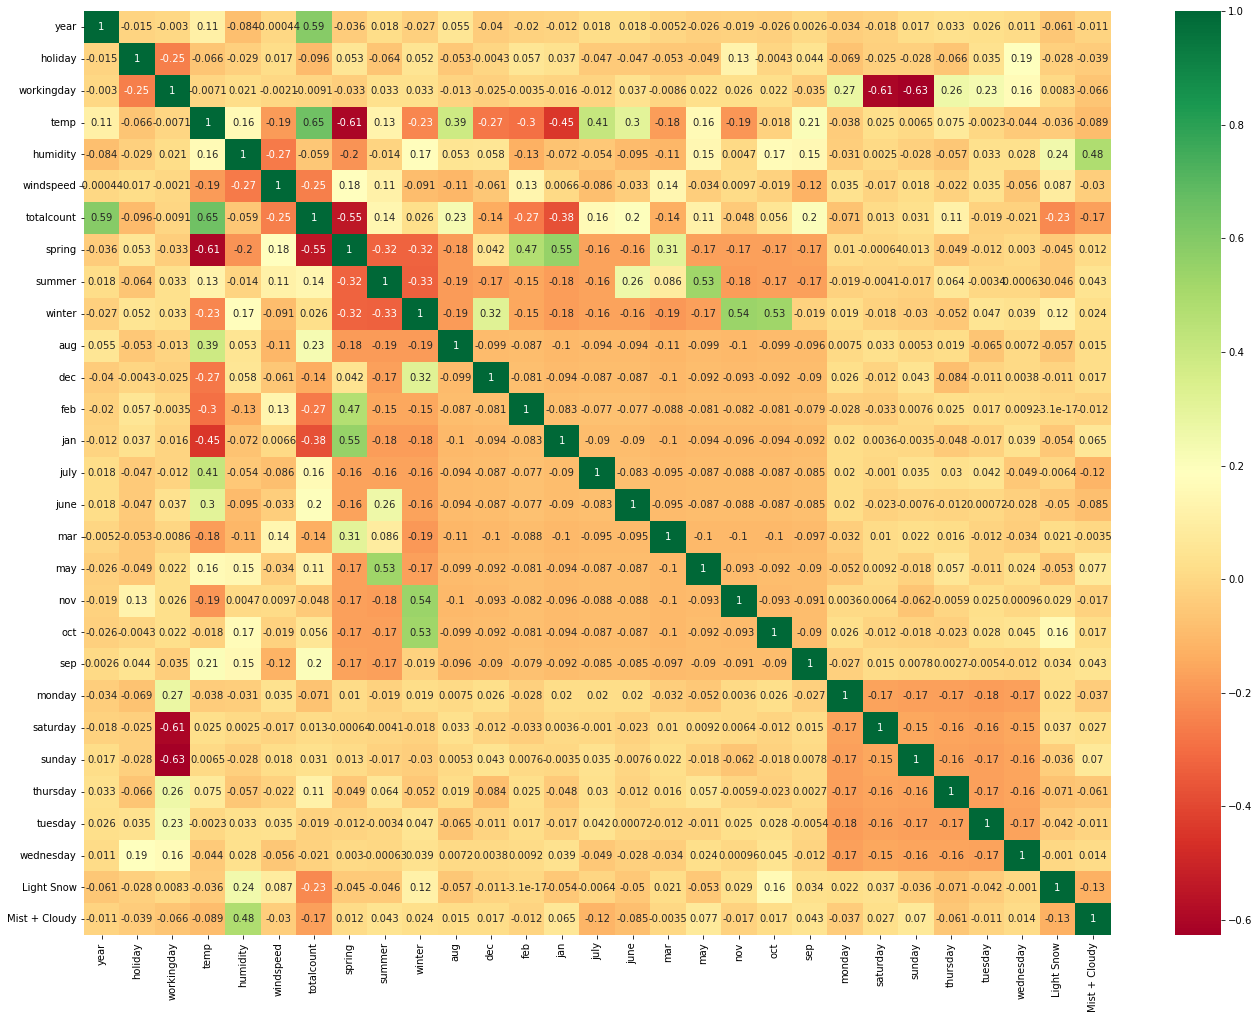

In [30]:
# lets find correlation coefficients to check correlation using Heatmap
plt.figure(figsize=(23,17))
sns.heatmap(boombk_train.corr(),annot=True,cmap = 'RdYlGn')
plt.show()

### Dividing into X and Y sets for the model building

In [31]:
y_train = boombk_train.pop('totalcount')
X_train = boombk_train

## Step 5: Building a linear model

### Adding all the variables to the model
- we keep removing variables from the model until we get a good R-squared value and p value.

In [32]:
# checking all the columns of the dataframe
boombikes.columns

Index(['year', 'holiday', 'workingday', 'temp', 'humidity', 'windspeed',
       'totalcount', 'spring', 'summer', 'winter', 'aug', 'dec', 'feb', 'jan',
       'july', 'june', 'mar', 'may', 'nov', 'oct', 'sep', 'monday', 'saturday',
       'sunday', 'thursday', 'tuesday', 'wednesday', 'Light Snow',
       'Mist + Cloudy'],
      dtype='object')

### Remember that in statsmodels, you need to explicitly fit a constant using sm.add_constant(X) because if we don't perform this step, statsmodels fits a regression line passing through the origin, by default.

In [33]:
# Build models with all the variables
X_train_sm = sm.add_constant(X_train)

# create and fit the model
lr = sm.OLS(y_train,X_train_sm).fit()

# check the parameters p-value,R-squared,coeffecients
lr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             totalcount   R-squared:                       0.850
Model:                            OLS   Adj. R-squared:                  0.841
Method:                 Least Squares   F-statistic:                     97.49
Date:                Sun, 04 Dec 2022   Prob (F-statistic):          1.34e-178
Time:                        22:59:27   Log-Likelihood:                 522.99
No. Observations:                 510   AIC:                            -988.0
Df Residuals:                     481   BIC:                            -865.2
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.3912      0.085      4.594      0.000       0.224       0.558
year              0.2311      0.008     28.384      0.000       0.215       0.247
holiday          -0.1348      0.065     -2.059      0.040      -0.263      -0.006
workingday       -0.0600      0.071     -0.844      0.399      -0.200       0.080
temp              0.4405      0.047      9.412      0.000       0.349       0.532
humidity         -0.1574      0.039     -4.043      0.000      -0.234      -0.081
windspeed        -0.1825      0.026     -7.003      0.000      -0.234      -0.131
spring           -0.0404      0.030     -1.335      0.182      -0.100       0.019
summer            0.0464      0.026      1.761      0.079      -0.005       0.098
winter            0.1126      0.028      3.994      0.000       0.057       0.168
aug               0.0273      0.034      0.806      0.421      -0.039       0.094
dec              -0.0444      0.034     -1.309      0.191      -0.111       0.022
feb              -0.0374      0.033     -1.123      0.262      -0.103       0.028
jan              -0.0642      0.034     -1.894      0.059      -0.131       0.002
july             -0.0285      0.035     -0.808      0.420      -0.098       0.041
june              0.0084      0.025      0.336      0.737      -0.041       0.058
mar               0.0008      0.025      0.032      0.974      -0.048       0.050
may               0.0247      0.021      1.164      0.245      -0.017       0.066
nov              -0.0396      0.037     -1.077      0.282      -0.112       0.033
oct               0.0056      0.036      0.156      0.876      -0.066       0.077
sep               0.0908      0.032      2.822      0.005       0.028       0.154
monday           -0.0246      0.015     -1.687      0.092      -0.053       0.004
saturday         -0.0557      0.072     -0.777      0.437      -0.197       0.085
sunday           -0.0495      0.072     -0.691      0.490      -0.190       0.091
thursday          0.0042      0.015      0.282      0.778      -0.025       0.034
tuesday          -0.0261      0.015     -1.774      0.077      -0.055       0.003
wednesday        -0.0102      0.015     -0.669      0.504      -0.040       0.020
Light Snow       -0.2499      0.027     -9.380      0.000      -0.302      -0.198
Mist + Cloudy    -0.0578      0.011     -5.495      0.000      -0.079      -0.037
==============================================================================
Omnibus:                       78.047   Durbin-Watson:                   2.007
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              205.442
Skew:                          -0.762   Prob(JB):                     2.45e-45
Kurtosis:                       5.710   Cond. No.                         70.4
================================================================

### We can make decision to remove variables on the basis of:
- Significance(p-values)
  - significance should be less then 0.05 which is mostly used value.
- VIF(variation inflation factor)
  - VIF should be less then 5 as when you use VIF value = 5 and calculate R-square which comes out to be 0.8 which is pretty high so we can accept values lower than that in our model.

### Checking VIF

Variance Inflation Factor or VIF, gives a basic quantitative idea about how much the feature variables are correlated with each other. It is an extremely important parameter to test our linear model. The formula for calculating `VIF` is:

### $ VIF_i = \frac{1}{1 - {R_i}^2} $

In [34]:
# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X_train.columns
vif['VIF'] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
2,workingday,63.89
3,temp,43.77
4,humidity,41.18
6,spring,13.50
8,winter,12.40
22,sunday,12.34
21,saturday,11.83
7,summer,9.85
17,nov,7.16
18,oct,6.82


We generally want a VIF that is less than 5. So there are clearly some variables we need to drop.

### - We could drop:
- High(p-value), High VIF
- which basically means less significant, High VIF means highly co-related.

### - Take a decision on this:
- High-Low:
   - High p,low VIF --> Remove this first.
   - Low p,high VIF --> Remove this after the one above is done.so it will calculate VIF again and then we might get a new VIF value.

### - We could keep:
- Low p, Low VIF

In [35]:
# Since the significance of march is very high we will drop that variable.
X = X_train.drop('mar',axis=1)

## Model 1

In [36]:
# Use the new variable X and add constant
X_train_sm = sm.add_constant(X)

# create and fit model
lr = sm.OLS(y_train,X_train_sm).fit()

# check the parameters
lr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             totalcount   R-squared:                       0.850
Model:                            OLS   Adj. R-squared:                  0.842
Method:                 Least Squares   F-statistic:                     101.3
Date:                Sun, 04 Dec 2022   Prob (F-statistic):          1.32e-179
Time:                        22:59:27   Log-Likelihood:                 522.99
No. Observations:                 510   AIC:                            -990.0
Df Residuals:                     482   BIC:                            -871.4
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.3917      0.084      4.684      0.000       0.227       0.556
year              0.2311      0.008     28.414      0.000       0.215       0.247
holiday          -0.1348      0.065     -2.061      0.040      -0.263      -0.006
workingday       -0.0600      0.071     -0.845      0.399      -0.200       0.080
temp              0.4403      0.046      9.550      0.000       0.350       0.531
humidity         -0.1573      0.039     -4.057      0.000      -0.233      -0.081
windspeed        -0.1825      0.026     -7.020      0.000      -0.234      -0.131
spring           -0.0401      0.029     -1.401      0.162      -0.096       0.016
summer            0.0463      0.026      1.790      0.074      -0.005       0.097
winter            0.1128      0.028      4.075      0.000       0.058       0.167
aug               0.0269      0.032      0.843      0.399      -0.036       0.090
dec              -0.0451      0.026     -1.718      0.086      -0.097       0.006
feb              -0.0382      0.022     -1.699      0.090      -0.082       0.006
jan              -0.0650      0.023     -2.883      0.004      -0.109      -0.021
july             -0.0288      0.034     -0.858      0.391      -0.095       0.037
june              0.0081      0.024      0.344      0.731      -0.038       0.055
may               0.0245      0.020      1.233      0.218      -0.015       0.064
nov              -0.0402      0.031     -1.293      0.197      -0.101       0.021
oct               0.0050      0.031      0.162      0.871      -0.056       0.066
sep               0.0904      0.029      3.092      0.002       0.033       0.148
monday           -0.0246      0.015     -1.692      0.091      -0.053       0.004
saturday         -0.0557      0.072     -0.778      0.437      -0.196       0.085
sunday           -0.0494      0.072     -0.691      0.490      -0.190       0.091
thursday          0.0042      0.015      0.283      0.778      -0.025       0.034
tuesday          -0.0261      0.015     -1.778      0.076      -0.055       0.003
wednesday        -0.0102      0.015     -0.671      0.503      -0.040       0.020
Light Snow       -0.2499      0.027     -9.390      0.000      -0.302      -0.198
Mist + Cloudy    -0.0579      0.011     -5.502      0.000      -0.079      -0.037
==============================================================================
Omnibus:                       78.028   Durbin-Watson:                   2.007
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              205.533
Skew:                          -0.762   Prob(JB):                     2.34e-45
Kurtosis:                       5.711   Cond. No.                         70.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of th

## Checking VIF also

In [37]:
vif = pd.DataFrame()
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
2,workingday,57.64
3,temp,43.12
4,humidity,40.57
8,winter,11.85
6,spring,11.56
21,sunday,11.11
20,saturday,10.72
7,summer,9.64
9,aug,6.15
5,windspeed,5.59


- R-squared still remains the same so this is a good sign.
- You can check that VIF of workingday has decreased from 63.89 to 57.64 which is good, so we will continue in this way.

In [38]:
# Dropping october(pvalue = 0.871)
X = X.drop('oct',axis=1)

## Model 2

In [39]:
# Use the new variable X and add constant
X_train_sm = sm.add_constant(X)

# create and fit model
lr = sm.OLS(y_train,X_train_sm).fit()

# check the parameters
lr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             totalcount   R-squared:                       0.850
Model:                            OLS   Adj. R-squared:                  0.842
Method:                 Least Squares   F-statistic:                     105.4
Date:                Sun, 04 Dec 2022   Prob (F-statistic):          1.29e-180
Time:                        22:59:27   Log-Likelihood:                 522.97
No. Observations:                 510   AIC:                            -991.9
Df Residuals:                     483   BIC:                            -877.6
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.3932      0.083      4.736      0.000       0.230       0.556
year              0.2311      0.008     28.466      0.000       0.215       0.247
holiday          -0.1347      0.065     -2.062      0.040      -0.263      -0.006
workingday       -0.0603      0.071     -0.850      0.396      -0.200       0.079
temp              0.4407      0.046      9.587      0.000       0.350       0.531
humidity         -0.1567      0.039     -4.065      0.000      -0.232      -0.081
windspeed        -0.1824      0.026     -7.026      0.000      -0.233      -0.131
spring           -0.0410      0.028     -1.467      0.143      -0.096       0.014
summer            0.0447      0.024      1.872      0.062      -0.002       0.092
winter            0.1149      0.024      4.701      0.000       0.067       0.163
aug               0.0249      0.029      0.848      0.397      -0.033       0.083
dec              -0.0481      0.019     -2.586      0.010      -0.085      -0.012
feb              -0.0390      0.022     -1.783      0.075      -0.082       0.004
jan              -0.0658      0.022     -2.991      0.003      -0.109      -0.023
july             -0.0309      0.031     -0.990      0.323      -0.092       0.030
june              0.0072      0.023      0.314      0.754      -0.038       0.052
may               0.0241      0.020      1.224      0.222      -0.015       0.063
nov              -0.0441      0.019     -2.289      0.022      -0.082      -0.006
sep               0.0879      0.025      3.527      0.000       0.039       0.137
monday           -0.0245      0.015     -1.687      0.092      -0.053       0.004
saturday         -0.0559      0.072     -0.782      0.435      -0.196       0.085
sunday           -0.0497      0.071     -0.696      0.487      -0.190       0.091
thursday          0.0043      0.015      0.285      0.776      -0.025       0.034
tuesday          -0.0261      0.015     -1.779      0.076      -0.055       0.003
wednesday        -0.0102      0.015     -0.668      0.504      -0.040       0.020
Light Snow       -0.2498      0.027     -9.398      0.000      -0.302      -0.198
Mist + Cloudy    -0.0579      0.011     -5.514      0.000      -0.079      -0.037
==============================================================================
Omnibus:                       77.463   Durbin-Watson:                   2.007
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              202.904
Skew:                          -0.758   Prob(JB):                     8.71e-45
Kurtosis:                       5.692   Cond. No.                         70.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [40]:
vif = pd.DataFrame()
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
2,workingday,56.51
3,temp,42.75
4,humidity,39.94
6,spring,11.18
20,sunday,10.87
19,saturday,10.47
8,winter,8.98
7,summer,8.34
5,windspeed,5.57
9,aug,5.27


In [41]:
# Dropping thursday(pvalue = 0.776)
X = X.drop('thursday',axis=1)

## Model 3

In [42]:
# Use the new variable X and add constant
X_train_sm = sm.add_constant(X)

# create and fit model
lr = sm.OLS(y_train,X_train_sm).fit()

# check the parameters
lr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             totalcount   R-squared:                       0.850
Model:                            OLS   Adj. R-squared:                  0.842
Method:                 Least Squares   F-statistic:                     109.8
Date:                Sun, 04 Dec 2022   Prob (F-statistic):          1.27e-181
Time:                        22:59:27   Log-Likelihood:                 522.93
No. Observations:                 510   AIC:                            -993.9
Df Residuals:                     484   BIC:                            -883.8
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.3953      0.083      4.785      0.000       0.233       0.558
year              0.2311      0.008     28.512      0.000       0.215       0.247
holiday          -0.1347      0.065     -2.064      0.040      -0.263      -0.006
workingday       -0.0601      0.071     -0.848      0.397      -0.199       0.079
temp              0.4409      0.046      9.600      0.000       0.351       0.531
humidity         -0.1570      0.038     -4.080      0.000      -0.233      -0.081
windspeed        -0.1825      0.026     -7.039      0.000      -0.233      -0.132
spring           -0.0412      0.028     -1.473      0.141      -0.096       0.014
summer            0.0448      0.024      1.881      0.061      -0.002       0.092
winter            0.1150      0.024      4.712      0.000       0.067       0.163
aug               0.0249      0.029      0.848      0.397      -0.033       0.083
dec              -0.0484      0.019     -2.609      0.009      -0.085      -0.012
feb              -0.0388      0.022     -1.775      0.077      -0.082       0.004
jan              -0.0658      0.022     -2.993      0.003      -0.109      -0.023
july             -0.0307      0.031     -0.985      0.325      -0.092       0.031
june              0.0068      0.023      0.299      0.765      -0.038       0.052
may               0.0241      0.020      1.224      0.222      -0.015       0.063
nov              -0.0443      0.019     -2.302      0.022      -0.082      -0.006
sep               0.0879      0.025      3.528      0.000       0.039       0.137
monday           -0.0266      0.013     -2.120      0.034      -0.051      -0.002
saturday         -0.0578      0.071     -0.813      0.417      -0.198       0.082
sunday           -0.0516      0.071     -0.726      0.468      -0.191       0.088
tuesday          -0.0282      0.013     -2.234      0.026      -0.053      -0.003
wednesday        -0.0123      0.013     -0.918      0.359      -0.039       0.014
Light Snow       -0.2505      0.026     -9.476      0.000      -0.302      -0.199
Mist + Cloudy    -0.0580      0.010     -5.529      0.000      -0.079      -0.037
==============================================================================
Omnibus:                       77.776   Durbin-Watson:                   2.008
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              204.211
Skew:                          -0.761   Prob(JB):                     4.53e-45
Kurtosis:                       5.701   Cond. No.                         69.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [43]:
vif = pd.DataFrame()
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
2,workingday,54.72
3,temp,42.69
4,humidity,39.94
6,spring,11.18
20,sunday,10.86
19,saturday,10.46
8,winter,8.97
7,summer,8.32
5,windspeed,5.57
9,aug,5.27


In [44]:
# Dropping june (0.765)
X = X.drop('june',axis=1)

## Model 4

In [45]:
# Use the new variable X and add constant
X_train_sm = sm.add_constant(X)

# create and fit model
lr = sm.OLS(y_train,X_train_sm).fit()

# check the parameters
lr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             totalcount   R-squared:                       0.850
Model:                            OLS   Adj. R-squared:                  0.843
Method:                 Least Squares   F-statistic:                     114.6
Date:                Sun, 04 Dec 2022   Prob (F-statistic):          1.22e-182
Time:                        22:59:28   Log-Likelihood:                 522.88
No. Observations:                 510   AIC:                            -995.8
Df Residuals:                     485   BIC:                            -889.9
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.3950      0.083      4.786      0.000       0.233       0.557
year              0.2309      0.008     28.619      0.000       0.215       0.247
holiday          -0.1346      0.065     -2.064      0.040      -0.263      -0.006
workingday       -0.0593      0.071     -0.838      0.402      -0.198       0.080
temp              0.4482      0.039     11.556      0.000       0.372       0.524
humidity         -0.1586      0.038     -4.164      0.000      -0.233      -0.084
windspeed        -0.1833      0.026     -7.121      0.000      -0.234      -0.133
spring           -0.0434      0.027     -1.618      0.106      -0.096       0.009
summer            0.0436      0.023      1.859      0.064      -0.002       0.090
winter            0.1125      0.023      4.917      0.000       0.068       0.157
aug               0.0198      0.024      0.830      0.407      -0.027       0.067
dec              -0.0476      0.018     -2.595      0.010      -0.084      -0.012
feb              -0.0379      0.022     -1.752      0.080      -0.080       0.005
jan              -0.0644      0.021     -3.003      0.003      -0.106      -0.022
july             -0.0363      0.025     -1.459      0.145      -0.085       0.013
may               0.0214      0.017      1.225      0.221      -0.013       0.056
nov              -0.0439      0.019     -2.288      0.023      -0.082      -0.006
sep               0.0842      0.022      3.896      0.000       0.042       0.127
monday           -0.0263      0.013     -2.107      0.036      -0.051      -0.002
saturday         -0.0570      0.071     -0.803      0.422      -0.197       0.083
sunday           -0.0508      0.071     -0.716      0.474      -0.190       0.089
tuesday          -0.0281      0.013     -2.228      0.026      -0.053      -0.003
wednesday        -0.0122      0.013     -0.911      0.363      -0.038       0.014
Light Snow       -0.2504      0.026     -9.481      0.000      -0.302      -0.199
Mist + Cloudy    -0.0578      0.010     -5.526      0.000      -0.078      -0.037
==============================================================================
Omnibus:                       77.293   Durbin-Watson:                   2.007
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              200.659
Skew:                          -0.760   Prob(JB):                     2.68e-44
Kurtosis:                       5.671   Cond. No.                         69.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [46]:
# Calculating VIF
vif = pd.DataFrame()
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
2,workingday,54.55
4,humidity,39.11
3,temp,29.71
19,sunday,10.82
18,saturday,10.44
6,spring,10.24
7,summer,8.04
8,winter,7.81
5,windspeed,5.50
9,aug,3.44


In [47]:
# Dropping sunday (pvalue = 0.474 & VIF = 10.82)
X = X.drop('sunday',axis=1)

## Model 5

In [48]:
# Use the new variable X and add constant
X_train_sm = sm.add_constant(X)

# create and fit model
lr = sm.OLS(y_train,X_train_sm).fit()

# check the parameters
lr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             totalcount   R-squared:                       0.850
Model:                            OLS   Adj. R-squared:                  0.843
Method:                 Least Squares   F-statistic:                     119.7
Date:                Sun, 04 Dec 2022   Prob (F-statistic):          1.42e-183
Time:                        22:59:28   Log-Likelihood:                 522.61
No. Observations:                 510   AIC:                            -997.2
Df Residuals:                     486   BIC:                            -895.6
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.3436      0.041      8.442      0.000       0.264       0.424
year              0.2313      0.008     28.724      0.000       0.215       0.247
holiday          -0.0926      0.029     -3.247      0.001      -0.149      -0.037
workingday       -0.0095      0.013     -0.732      0.465      -0.035       0.016
temp              0.4490      0.039     11.588      0.000       0.373       0.525
humidity         -0.1575      0.038     -4.140      0.000      -0.232      -0.083
windspeed        -0.1838      0.026     -7.147      0.000      -0.234      -0.133
spring           -0.0431      0.027     -1.608      0.109      -0.096       0.010
summer            0.0437      0.023      1.863      0.063      -0.002       0.090
winter            0.1123      0.023      4.910      0.000       0.067       0.157
aug               0.0194      0.024      0.816      0.415      -0.027       0.066
dec              -0.0474      0.018     -2.584      0.010      -0.083      -0.011
feb              -0.0375      0.022     -1.736      0.083      -0.080       0.005
jan              -0.0641      0.021     -2.995      0.003      -0.106      -0.022
july             -0.0367      0.025     -1.476      0.141      -0.085       0.012
may               0.0211      0.017      1.209      0.227      -0.013       0.055
nov              -0.0451      0.019     -2.364      0.018      -0.083      -0.008
sep               0.0843      0.022      3.904      0.000       0.042       0.127
monday           -0.0258      0.012     -2.069      0.039      -0.050      -0.001
saturday         -0.0074      0.015     -0.483      0.629      -0.037       0.023
tuesday          -0.0273      0.013     -2.174      0.030      -0.052      -0.003
wednesday        -0.0109      0.013     -0.824      0.411      -0.037       0.015
Light Snow       -0.2503      0.026     -9.480      0.000      -0.302      -0.198
Mist + Cloudy    -0.0578      0.010     -5.529      0.000      -0.078      -0.037
==============================================================================
Omnibus:                       77.267   Durbin-Watson:                   2.007
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              197.188
Skew:                          -0.765   Prob(JB):                     1.52e-43
Kurtosis:                       5.634   Cond. No.                         27.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [49]:
# Calculating VIF
vif = pd.DataFrame()
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
4,humidity,34.32
3,temp,21.83
2,workingday,7.46
6,spring,7.37
8,winter,5.99
7,summer,5.87
5,windspeed,4.96
9,aug,3.14
13,july,2.79
12,jan,2.42


In [50]:
# Dropping saturday (pvalue = 0.629)
X = X.drop('saturday',axis=1)

## Model 6

In [51]:
# Use the new variable X and add constant
X_train_sm = sm.add_constant(X)

# create and fit model
lr = sm.OLS(y_train,X_train_sm).fit()

# check the parameters
lr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             totalcount   R-squared:                       0.850
Model:                            OLS   Adj. R-squared:                  0.843
Method:                 Least Squares   F-statistic:                     125.3
Date:                Sun, 04 Dec 2022   Prob (F-statistic):          1.41e-184
Time:                        22:59:28   Log-Likelihood:                 522.49
No. Observations:                 510   AIC:                            -999.0
Df Residuals:                     487   BIC:                            -901.6
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.3403      0.040      8.486      0.000       0.262       0.419
year              0.2314      0.008     28.774      0.000       0.216       0.247
holiday          -0.0895      0.028     -3.223      0.001      -0.144      -0.035
workingday       -0.0059      0.011     -0.556      0.579      -0.027       0.015
temp              0.4486      0.039     11.590      0.000       0.373       0.525
humidity         -0.1575      0.038     -4.144      0.000      -0.232      -0.083
windspeed        -0.1835      0.026     -7.143      0.000      -0.234      -0.133
spring           -0.0436      0.027     -1.626      0.105      -0.096       0.009
summer            0.0434      0.023      1.852      0.065      -0.003       0.089
winter            0.1120      0.023      4.905      0.000       0.067       0.157
aug               0.0191      0.024      0.803      0.422      -0.028       0.066
dec              -0.0472      0.018     -2.578      0.010      -0.083      -0.011
feb              -0.0372      0.022     -1.726      0.085      -0.080       0.005
jan              -0.0641      0.021     -2.998      0.003      -0.106      -0.022
july             -0.0367      0.025     -1.477      0.140      -0.085       0.012
may               0.0210      0.017      1.205      0.229      -0.013       0.055
nov              -0.0456      0.019     -2.397      0.017      -0.083      -0.008
sep               0.0841      0.022      3.899      0.000       0.042       0.126
monday           -0.0258      0.012     -2.069      0.039      -0.050      -0.001
tuesday          -0.0273      0.013     -2.174      0.030      -0.052      -0.003
wednesday        -0.0108      0.013     -0.819      0.413      -0.037       0.015
Light Snow       -0.2508      0.026     -9.516      0.000      -0.303      -0.199
Mist + Cloudy    -0.0577      0.010     -5.524      0.000      -0.078      -0.037
==============================================================================
Omnibus:                       76.140   Durbin-Watson:                   2.003
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              194.055
Skew:                          -0.755   Prob(JB):                     7.27e-43
Kurtosis:                       5.618   Cond. No.                         27.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [52]:
# Calculating VIF
vif = pd.DataFrame()
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
4,humidity,34.11
3,temp,21.39
6,spring,7.17
8,winter,5.89
7,summer,5.74
2,workingday,5.15
5,windspeed,4.95
9,aug,3.12
13,july,2.78
12,jan,2.41


In [53]:
# Dropping wednesday(pvalue = 0.413)
X = X.drop('wednesday',axis=1)

## Model 7

In [54]:
# Use the new variable X and add constant
X_train_sm = sm.add_constant(X)

# create and fit model
lr = sm.OLS(y_train,X_train_sm).fit()

# check the parameters
lr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             totalcount   R-squared:                       0.850
Model:                            OLS   Adj. R-squared:                  0.843
Method:                 Least Squares   F-statistic:                     131.4
Date:                Sun, 04 Dec 2022   Prob (F-statistic):          1.69e-185
Time:                        22:59:28   Log-Likelihood:                 522.14
No. Observations:                 510   AIC:                            -1000.
Df Residuals:                     488   BIC:                            -907.1
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.3398      0.040      8.477      0.000       0.261       0.419
year              0.2312      0.008     28.772      0.000       0.215       0.247
holiday          -0.0964      0.026     -3.639      0.000      -0.148      -0.044
workingday       -0.0092      0.010     -0.929      0.353      -0.029       0.010
temp              0.4501      0.039     11.645      0.000       0.374       0.526
humidity         -0.1577      0.038     -4.152      0.000      -0.232      -0.083
windspeed        -0.1828      0.026     -7.122      0.000      -0.233      -0.132
spring           -0.0434      0.027     -1.621      0.106      -0.096       0.009
summer            0.0432      0.023      1.845      0.066      -0.003       0.089
winter            0.1113      0.023      4.878      0.000       0.066       0.156
aug               0.0185      0.024      0.778      0.437      -0.028       0.065
dec              -0.0468      0.018     -2.559      0.011      -0.083      -0.011
feb              -0.0372      0.022     -1.724      0.085      -0.080       0.005
jan              -0.0644      0.021     -3.012      0.003      -0.106      -0.022
july             -0.0372      0.025     -1.500      0.134      -0.086       0.012
may               0.0207      0.017      1.190      0.234      -0.013       0.055
nov              -0.0444      0.019     -2.341      0.020      -0.082      -0.007
sep               0.0842      0.022      3.904      0.000       0.042       0.127
monday           -0.0225      0.012     -1.908      0.057      -0.046       0.001
tuesday          -0.0239      0.012     -2.018      0.044      -0.047      -0.001
Light Snow       -0.2507      0.026     -9.516      0.000      -0.302      -0.199
Mist + Cloudy    -0.0578      0.010     -5.541      0.000      -0.078      -0.037
==============================================================================
Omnibus:                       76.107   Durbin-Watson:                   2.005
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              195.517
Skew:                          -0.752   Prob(JB):                     3.50e-43
Kurtosis:                       5.634   Cond. No.                         27.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [55]:
# Calculating VIF
vif = pd.DataFrame()
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
4,humidity,34.10
3,temp,21.34
6,spring,7.17
8,winter,5.87
7,summer,5.74
5,windspeed,4.95
2,workingday,4.41
9,aug,3.11
13,july,2.78
12,jan,2.41


In [56]:
# Dropping August (pvalue = 0.437)
X = X.drop('aug',axis=1)

## Model 8

In [57]:
# Use the new variable X and add constant
X_train_sm = sm.add_constant(X)

# create and fit model
lr = sm.OLS(y_train,X_train_sm).fit()

# check the parameters
lr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             totalcount   R-squared:                       0.850
Model:                            OLS   Adj. R-squared:                  0.843
Method:                 Least Squares   F-statistic:                     138.0
Date:                Sun, 04 Dec 2022   Prob (F-statistic):          1.92e-186
Time:                        22:59:28   Log-Likelihood:                 521.83
No. Observations:                 510   AIC:                            -1002.
Df Residuals:                     489   BIC:                            -912.7
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.3502      0.038      9.275      0.000       0.276       0.424
year              0.2314      0.008     28.819      0.000       0.216       0.247
holiday          -0.0969      0.026     -3.663      0.000      -0.149      -0.045
workingday       -0.0094      0.010     -0.945      0.345      -0.029       0.010
temp              0.4523      0.039     11.739      0.000       0.377       0.528
humidity         -0.1564      0.038     -4.123      0.000      -0.231      -0.082
windspeed        -0.1830      0.026     -7.132      0.000      -0.233      -0.133
spring           -0.0552      0.022     -2.503      0.013      -0.099      -0.012
summer            0.0307      0.017      1.803      0.072      -0.003       0.064
winter            0.1004      0.018      5.585      0.000       0.065       0.136
dec              -0.0478      0.018     -2.616      0.009      -0.084      -0.012
feb              -0.0372      0.022     -1.724      0.085      -0.080       0.005
jan              -0.0644      0.021     -3.013      0.003      -0.106      -0.022
july             -0.0504      0.018     -2.776      0.006      -0.086      -0.015
may               0.0203      0.017      1.168      0.243      -0.014       0.055
nov              -0.0456      0.019     -2.412      0.016      -0.083      -0.008
sep               0.0736      0.017      4.393      0.000       0.041       0.107
monday           -0.0222      0.012     -1.883      0.060      -0.045       0.001
tuesday          -0.0240      0.012     -2.030      0.043      -0.047      -0.001
Light Snow       -0.2517      0.026     -9.570      0.000      -0.303      -0.200
Mist + Cloudy    -0.0575      0.010     -5.519      0.000      -0.078      -0.037
==============================================================================
Omnibus:                       77.267   Durbin-Watson:                   2.007
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              198.316
Skew:                          -0.763   Prob(JB):                     8.63e-44
Kurtosis:                       5.646   Cond. No.                         24.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [58]:
# Calculating VIF
vif = pd.DataFrame()
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
4,humidity,32.50
3,temp,18.63
6,spring,5.48
5,windspeed,4.88
2,workingday,4.41
8,winter,4.11
7,summer,3.38
11,jan,2.39
19,Mist + Cloudy,2.37
0,year,2.11


In [59]:
# Dropping workingday(pvalue = 0.345)
X = X.drop('workingday',axis=1)

## Model 9

In [60]:
# Use the new variable X and add constant
X_train_sm = sm.add_constant(X)

# create and fit model
lr = sm.OLS(y_train,X_train_sm).fit()

# check the parameters
lr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             totalcount   R-squared:                       0.849
Model:                            OLS   Adj. R-squared:                  0.843
Method:                 Least Squares   F-statistic:                     145.3
Date:                Sun, 04 Dec 2022   Prob (F-statistic):          2.45e-187
Time:                        22:59:28   Log-Likelihood:                 521.36
No. Observations:                 510   AIC:                            -1003.
Df Residuals:                     490   BIC:                            -918.0
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.3449      0.037      9.238      0.000       0.272       0.418
year              0.2314      0.008     28.820      0.000       0.216       0.247
holiday          -0.0902      0.025     -3.540      0.000      -0.140      -0.040
temp              0.4530      0.039     11.758      0.000       0.377       0.529
humidity         -0.1584      0.038     -4.183      0.000      -0.233      -0.084
windspeed        -0.1827      0.026     -7.120      0.000      -0.233      -0.132
spring           -0.0548      0.022     -2.484      0.013      -0.098      -0.011
summer            0.0307      0.017      1.800      0.072      -0.003       0.064
winter            0.1004      0.018      5.589      0.000       0.065       0.136
dec              -0.0472      0.018     -2.588      0.010      -0.083      -0.011
feb              -0.0377      0.022     -1.749      0.081      -0.080       0.005
jan              -0.0646      0.021     -3.021      0.003      -0.107      -0.023
july             -0.0497      0.018     -2.741      0.006      -0.085      -0.014
may               0.0201      0.017      1.153      0.249      -0.014       0.054
nov              -0.0461      0.019     -2.442      0.015      -0.083      -0.009
sep               0.0739      0.017      4.412      0.000       0.041       0.107
monday           -0.0258      0.011     -2.318      0.021      -0.048      -0.004
tuesday          -0.0275      0.011     -2.446      0.015      -0.050      -0.005
Light Snow       -0.2511      0.026     -9.552      0.000      -0.303      -0.199
Mist + Cloudy    -0.0566      0.010     -5.454      0.000      -0.077      -0.036
==============================================================================
Omnibus:                       74.663   Durbin-Watson:                   2.008
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              195.519
Skew:                          -0.732   Prob(JB):                     3.50e-43
Kurtosis:                       5.657   Cond. No.                         22.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [61]:
# Calculating VIF
vif = pd.DataFrame()
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
3,humidity,31.84
2,temp,18.41
5,spring,5.45
4,windspeed,4.87
7,winter,4.08
6,summer,3.35
10,jan,2.38
18,Mist + Cloudy,2.34
0,year,2.11
9,feb,1.92


In [62]:
# Dropping May (pvalue = 0.249)
X = X.drop('may',axis=1)

## Model 10

In [63]:
# Use the new variable X and add constant
X_train_sm = sm.add_constant(X)

# create and fit model
lr = sm.OLS(y_train,X_train_sm).fit()

# check the parameters
lr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             totalcount   R-squared:                       0.849
Model:                            OLS   Adj. R-squared:                  0.843
Method:                 Least Squares   F-statistic:                     153.2
Date:                Sun, 04 Dec 2022   Prob (F-statistic):          3.77e-188
Time:                        22:59:28   Log-Likelihood:                 520.67
No. Observations:                 510   AIC:                            -1003.
Df Residuals:                     491   BIC:                            -922.9
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.3360      0.037      9.195      0.000       0.264       0.408
year              0.2309      0.008     28.790      0.000       0.215       0.247
holiday          -0.0909      0.025     -3.570      0.000      -0.141      -0.041
temp              0.4607      0.038     12.142      0.000       0.386       0.535
humidity         -0.1529      0.038     -4.068      0.000      -0.227      -0.079
windspeed        -0.1841      0.026     -7.182      0.000      -0.234      -0.134
spring           -0.0515      0.022     -2.353      0.019      -0.094      -0.008
summer            0.0393      0.015      2.562      0.011       0.009       0.069
winter            0.1022      0.018      5.711      0.000       0.067       0.137
dec              -0.0461      0.018     -2.527      0.012      -0.082      -0.010
feb              -0.0365      0.022     -1.694      0.091      -0.079       0.006
jan              -0.0631      0.021     -2.957      0.003      -0.105      -0.021
july             -0.0500      0.018     -2.760      0.006      -0.086      -0.014
nov              -0.0447      0.019     -2.369      0.018      -0.082      -0.008
sep               0.0739      0.017      4.410      0.000       0.041       0.107
monday           -0.0264      0.011     -2.367      0.018      -0.048      -0.004
tuesday          -0.0278      0.011     -2.477      0.014      -0.050      -0.006
Light Snow       -0.2528      0.026     -9.626      0.000      -0.304      -0.201
Mist + Cloudy    -0.0568      0.010     -5.471      0.000      -0.077      -0.036
==============================================================================
Omnibus:                       73.404   Durbin-Watson:                   2.013
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              183.627
Skew:                          -0.735   Prob(JB):                     1.34e-40
Kurtosis:                       5.546   Cond. No.                         21.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [64]:
# Calculating VIF
vif = pd.DataFrame()
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
3,humidity,31.80
2,temp,18.36
5,spring,5.45
4,windspeed,4.78
7,winter,4.08
6,summer,2.82
10,jan,2.38
17,Mist + Cloudy,2.34
0,year,2.10
9,feb,1.92


In [65]:
# Dropping feb (pvalue = 0.091)
X = X.drop('feb',axis=1)

## Model 11

In [66]:
# Use the new variable X and add constant
X_train_sm = sm.add_constant(X)

# create and fit model
lr = sm.OLS(y_train,X_train_sm).fit()

# check the parameters
lr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             totalcount   R-squared:                       0.848
Model:                            OLS   Adj. R-squared:                  0.843
Method:                 Least Squares   F-statistic:                     161.4
Date:                Sun, 04 Dec 2022   Prob (F-statistic):          1.21e-188
Time:                        22:59:29   Log-Likelihood:                 519.18
No. Observations:                 510   AIC:                            -1002.
Df Residuals:                     492   BIC:                            -926.1
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.3239      0.036      9.021      0.000       0.253       0.394
year              0.2305      0.008     28.700      0.000       0.215       0.246
holiday          -0.0933      0.025     -3.662      0.000      -0.143      -0.043
temp              0.4771      0.037     12.975      0.000       0.405       0.549
humidity         -0.1549      0.038     -4.117      0.000      -0.229      -0.081
windspeed        -0.1829      0.026     -7.124      0.000      -0.233      -0.132
spring           -0.0615      0.021     -2.912      0.004      -0.103      -0.020
summer            0.0427      0.015      2.803      0.005       0.013       0.073
winter            0.1040      0.018      5.810      0.000       0.069       0.139
dec              -0.0366      0.017     -2.107      0.036      -0.071      -0.002
jan              -0.0436      0.018     -2.421      0.016      -0.079      -0.008
july             -0.0510      0.018     -2.812      0.005      -0.087      -0.015
nov              -0.0397      0.019     -2.128      0.034      -0.076      -0.003
sep               0.0755      0.017      4.502      0.000       0.043       0.108
monday           -0.0258      0.011     -2.309      0.021      -0.048      -0.004
tuesday          -0.0280      0.011     -2.487      0.013      -0.050      -0.006
Light Snow       -0.2514      0.026     -9.559      0.000      -0.303      -0.200
Mist + Cloudy    -0.0565      0.010     -5.432      0.000      -0.077      -0.036
==============================================================================
Omnibus:                       68.562   Durbin-Watson:                   2.014
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              170.059
Skew:                          -0.691   Prob(JB):                     1.18e-37
Kurtosis:                       5.468   Cond. No.                         21.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [67]:
# Calculating VIF
vif = pd.DataFrame()
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
3,humidity,31.17
2,temp,17.82
4,windspeed,4.77
5,spring,4.37
7,winter,4.08
6,summer,2.82
16,Mist + Cloudy,2.33
0,year,2.09
11,nov,1.85
9,jan,1.75


- Now since the all features have p-values less then 0.05, we will try to drop VIF's having high values probably more then 5.
- Since humidity has a very high value we will be dropping that.
- Also R-squared value has dropped by fraction from 0.850 to 0.848 which is still a good.

In [68]:
# Dropping humidity	(VIF = 31.17).
X = X.drop('humidity',axis=1)

## Model 12

In [69]:
# Use the new variable X and add constant
X_train_sm = sm.add_constant(X)

# create and fit model
lr = sm.OLS(y_train,X_train_sm).fit()

# check the parameters
lr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             totalcount   R-squared:                       0.843
Model:                            OLS   Adj. R-squared:                  0.838
Method:                 Least Squares   F-statistic:                     165.1
Date:                Sun, 04 Dec 2022   Prob (F-statistic):          3.68e-186
Time:                        22:59:29   Log-Likelihood:                 510.55
No. Observations:                 510   AIC:                            -987.1
Df Residuals:                     493   BIC:                            -915.1
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.2530      0.032      7.904      0.000       0.190       0.316
year              0.2344      0.008     28.932      0.000       0.219       0.250
holiday          -0.0938      0.026     -3.622      0.000      -0.145      -0.043
temp              0.4362      0.036     12.127      0.000       0.366       0.507
windspeed        -0.1536      0.025     -6.130      0.000      -0.203      -0.104
spring           -0.0708      0.021     -3.321      0.001      -0.113      -0.029
summer            0.0357      0.015      2.325      0.020       0.006       0.066
winter            0.0901      0.018      5.043      0.000       0.055       0.125
dec              -0.0438      0.018     -2.492      0.013      -0.078      -0.009
jan              -0.0499      0.018     -2.741      0.006      -0.086      -0.014
july             -0.0456      0.018     -2.481      0.013      -0.082      -0.010
nov              -0.0406      0.019     -2.141      0.033      -0.078      -0.003
sep               0.0692      0.017      4.077      0.000       0.036       0.103
monday           -0.0263      0.011     -2.316      0.021      -0.049      -0.004
tuesday          -0.0317      0.011     -2.785      0.006      -0.054      -0.009
Light Snow       -0.2951      0.024    -12.067      0.000      -0.343      -0.247
Mist + Cloudy    -0.0811      0.009     -9.397      0.000      -0.098      -0.064
==============================================================================
Omnibus:                       70.174   Durbin-Watson:                   2.013
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              175.393
Skew:                          -0.704   Prob(JB):                     8.20e-39
Kurtosis:                       5.504   Cond. No.                         19.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [70]:
# Calculating VIF
vif = pd.DataFrame()
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
2,temp,5.23
3,windspeed,4.70
6,winter,3.00
4,spring,2.92
5,summer,2.26
0,year,2.08
10,nov,1.81
8,jan,1.66
9,july,1.60
15,Mist + Cloudy,1.57


In [71]:
# Dropping temp as it has a higher VIF of 5.23.
X = X.drop('temp',axis=1)

## Model 13

In [72]:
# Use the new variable X and add constant
X_train_sm = sm.add_constant(X)

# create and fit model
lr = sm.OLS(y_train,X_train_sm).fit()

# check the parameters
lr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             totalcount   R-squared:                       0.796
Model:                            OLS   Adj. R-squared:                  0.790
Method:                 Least Squares   F-statistic:                     128.3
Date:                Sun, 04 Dec 2022   Prob (F-statistic):          1.90e-159
Time:                        22:59:29   Log-Likelihood:                 443.98
No. Observations:                 510   AIC:                            -856.0
Df Residuals:                     494   BIC:                            -788.2
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.6020      0.016     37.816      0.000       0.571       0.633
year              0.2455      0.009     26.790      0.000       0.228       0.264
holiday          -0.0884      0.029     -2.999      0.003      -0.146      -0.030
windspeed        -0.1848      0.028     -6.511      0.000      -0.241      -0.129
spring           -0.2489      0.018    -14.147      0.000      -0.283      -0.214
summer           -0.0484      0.016     -3.100      0.002      -0.079      -0.018
winter           -0.0191      0.018     -1.089      0.277      -0.054       0.015
dec              -0.1091      0.019     -5.727      0.000      -0.147      -0.072
jan              -0.1195      0.020     -6.068      0.000      -0.158      -0.081
july             -0.0139      0.021     -0.668      0.504      -0.055       0.027
nov              -0.1002      0.021     -4.804      0.000      -0.141      -0.059
sep               0.0538      0.019      2.795      0.005       0.016       0.092
monday           -0.0312      0.013     -2.418      0.016      -0.056      -0.006
tuesday          -0.0319      0.013     -2.458      0.014      -0.057      -0.006
Light Snow       -0.3148      0.028    -11.337      0.000      -0.369      -0.260
Mist + Cloudy    -0.0881      0.010     -8.982      0.000      -0.107      -0.069
==============================================================================
Omnibus:                       57.766   Durbin-Watson:                   1.927
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              139.823
Skew:                          -0.593   Prob(JB):                     4.34e-31
Kurtosis:                       5.274   Cond. No.                         9.42
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [73]:
# Calculating VIF
vif = pd.DataFrame()
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
2,windspeed,3.97
3,spring,2.91
5,winter,2.91
4,summer,2.05
0,year,1.84
9,nov,1.80
7,jan,1.64
14,Mist + Cloudy,1.53
6,dec,1.46
12,tuesday,1.23


- The value of p value for july has suddenly increased so we need to drop it.

In [74]:
# Dropping july (pvalue = 0.504)
X = X.drop('july',axis=1)

## Model 14

In [75]:
# Use the new variable X and add constant
X_train_sm = sm.add_constant(X)

# create and fit model
lr = sm.OLS(y_train,X_train_sm).fit()

# check the parameters
lr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             totalcount   R-squared:                       0.796
Model:                            OLS   Adj. R-squared:                  0.790
Method:                 Least Squares   F-statistic:                     137.6
Date:                Sun, 04 Dec 2022   Prob (F-statistic):          1.98e-160
Time:                        22:59:29   Log-Likelihood:                 443.75
No. Observations:                 510   AIC:                            -857.5
Df Residuals:                     495   BIC:                            -794.0
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.5970      0.014     42.660      0.000       0.569       0.624
year              0.2456      0.009     26.814      0.000       0.228       0.264
holiday          -0.0881      0.029     -2.992      0.003      -0.146      -0.030
windspeed        -0.1846      0.028     -6.508      0.000      -0.240      -0.129
spring           -0.2440      0.016    -15.256      0.000      -0.275      -0.213
summer           -0.0435      0.014     -3.161      0.002      -0.070      -0.016
winter           -0.0147      0.016     -0.905      0.366      -0.047       0.017
dec              -0.1087      0.019     -5.712      0.000      -0.146      -0.071
jan              -0.1195      0.020     -6.071      0.000      -0.158      -0.081
nov              -0.0996      0.021     -4.783      0.000      -0.141      -0.059
sep               0.0578      0.018      3.154      0.002       0.022       0.094
monday           -0.0314      0.013     -2.440      0.015      -0.057      -0.006
tuesday          -0.0325      0.013     -2.514      0.012      -0.058      -0.007
Light Snow       -0.3150      0.028    -11.348      0.000      -0.370      -0.260
Mist + Cloudy    -0.0876      0.010     -8.962      0.000      -0.107      -0.068
==============================================================================
Omnibus:                       58.044   Durbin-Watson:                   1.935
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              139.513
Skew:                          -0.598   Prob(JB):                     5.07e-31
Kurtosis:                       5.266   Cond. No.                         9.07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [76]:
# Calculating VIF
vif = pd.DataFrame()
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
2,windspeed,3.66
5,winter,2.79
3,spring,2.72
4,summer,1.88
8,nov,1.80
0,year,1.78
7,jan,1.64
13,Mist + Cloudy,1.52
6,dec,1.46
10,monday,1.21


In [77]:
# Dropping winter (pvalue = 0.366)
X = X.drop('winter',axis=1)

## Model 15

In [78]:
# Use the new variable X and add constant
X_train_sm = sm.add_constant(X)

# create and fit model
lr = sm.OLS(y_train,X_train_sm).fit()

# check the parameters
lr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             totalcount   R-squared:                       0.795
Model:                            OLS   Adj. R-squared:                  0.790
Method:                 Least Squares   F-statistic:                     148.2
Date:                Sun, 04 Dec 2022   Prob (F-statistic):          2.39e-161
Time:                        22:59:29   Log-Likelihood:                 443.32
No. Observations:                 510   AIC:                            -858.6
Df Residuals:                     496   BIC:                            -799.4
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.5927      0.013     45.004      0.000       0.567       0.619
year              0.2457      0.009     26.835      0.000       0.228       0.264
holiday          -0.0883      0.029     -2.998      0.003      -0.146      -0.030
windspeed        -0.1853      0.028     -6.538      0.000      -0.241      -0.130
spring           -0.2379      0.014    -16.432      0.000      -0.266      -0.209
summer           -0.0385      0.013     -3.053      0.002      -0.063      -0.014
dec              -0.1159      0.017     -6.709      0.000      -0.150      -0.082
jan              -0.1207      0.020     -6.149      0.000      -0.159      -0.082
nov              -0.1093      0.018     -6.129      0.000      -0.144      -0.074
sep               0.0595      0.018      3.270      0.001       0.024       0.095
monday           -0.0316      0.013     -2.455      0.014      -0.057      -0.006
tuesday          -0.0332      0.013     -2.573      0.010      -0.059      -0.008
Light Snow       -0.3182      0.028    -11.558      0.000      -0.372      -0.264
Mist + Cloudy    -0.0884      0.010     -9.076      0.000      -0.108      -0.069
==============================================================================
Omnibus:                       61.450   Durbin-Watson:                   1.929
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              152.690
Skew:                          -0.621   Prob(JB):                     6.98e-34
Kurtosis:                       5.375   Cond. No.                         8.92
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [79]:
# Calculating VIF
vif = pd.DataFrame()
vif['Features'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
2,windspeed,3.41
3,spring,2.37
0,year,1.76
4,summer,1.71
6,jan,1.63
12,Mist + Cloudy,1.48
7,nov,1.24
9,monday,1.20
10,tuesday,1.20
8,sep,1.16


### Final Model
1. R-squared = 0.7950(79.50%)
    adjusted r-squared = 0.7900(79.00%) Which is pretty good.
2. All VIF's value are less then 5 and p-values less then 0.05. 
3. Prob (F-statistic) is also ~ 0 so this shows model is significant now.
4. so this will be our final model.

## Step 6: Residual analysis of the train data
#### predicting y values of train data from X_train_sm.

In [80]:
y_train_pred = lr.predict(X_train_sm)

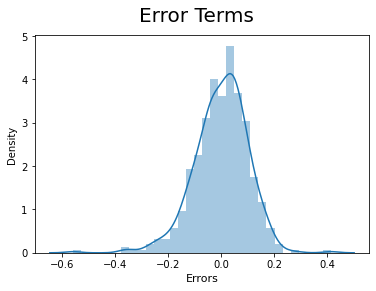

In [81]:
fig = plt.figure()
residual = y_train - y_train_pred
sns.distplot(residual)
fig.suptitle('Error Terms', fontsize = 20)                   
plt.xlabel('Errors', fontsize = 11)
plt.show()

# This distribution is normally distributed and is centred across 0 which is good.

# Predictions and evaluations on test set.

- Before predicting we need to scale the test set as well like we did for the training set.
- fit() - You fit scaler on training data set and not on test data like we did earlier.scaler learnsxmin,xmax from training data set.
- transform() - You then transform the test data set using scaler that has been fit on training data set(not on test data set)
- fit_transform() is just a combination of fit() and transform().

## Step 7: Making Predictions on test set using the Final Model
- Now that we have fitted the model and checked the normality of error terms, it's time to go ahead and make predictions using the final model.

## Points to remember while going ahead:
1. Do the scaling on test set of data as well because we have scaled the train data so if you dont do scaling then it will not throw an error but the model will be useless and wrong.
2. We will be just using transform() because in real world we dont have a test data set so we cannot fit a scaler on anything that we dont have it, here in our case we have a mimic version of test data but not in real world so we are fitting it on training data set and we transform the test data set using the scaler that has been fit on training data set.

#### Applying the scaling on the test sets

In [82]:
# create a list of numberic variables that you want to scale
num_vars = ['temp', 'humidity', 'windspeed', 'totalcount']

boombk_test[num_vars] = scaler.transform(boombk_test[num_vars])
boombk_test.head()

,year,holiday,workingday,temp,humidity,windspeed,totalcount,spring,summer,winter,...,oct,sep,monday,saturday,sunday,thursday,tuesday,wednesday,Light Snow,Mist + Cloudy
184,0,1,0,0.831783,0.657364,0.084219,0.692706,0,0,0,...,0,0,0,0,0,0,0,1,0,1
535,1,0,1,0.901354,0.610133,0.153728,0.712034,0,1,0,...,0,0,0,0,0,1,0,0,0,0
299,0,0,0,0.511964,0.837699,0.334206,0.303382,0,0,1,...,1,0,0,1,0,0,0,0,0,1
221,0,0,1,0.881625,0.437098,0.339570,0.547400,0,0,0,...,0,0,0,0,0,0,0,0,0,0
152,0,0,0,0.817246,0.314298,0.537414,0.569029,0,1,0,...,0,0,0,1,0,0,0,0,0,0


In [83]:
boombk_test.describe()

,year,holiday,workingday,temp,humidity,windspeed,totalcount,spring,summer,winter,...,oct,sep,monday,saturday,sunday,thursday,tuesday,wednesday,Light Snow,Mist + Cloudy
count,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,...,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000
mean,0.481818,0.036364,0.640909,0.558718,0.638221,0.313293,0.522154,0.254545,0.263636,0.236364,...,0.086364,0.086364,0.118182,0.172727,0.154545,0.140909,0.122727,0.159091,0.027273,0.318182
std,0.500809,0.187620,0.480828,0.233187,0.148694,0.159584,0.219163,0.436599,0.441609,0.425817,...,0.281541,0.281541,0.323559,0.378873,0.362295,0.348721,0.328872,0.366595,0.163248,0.466833
min,0.000000,0.000000,0.000000,0.046591,0.261915,-0.042808,0.048205,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.355429,0.529197,0.198843,0.378595,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,1.000000,0.558172,0.625590,0.300126,0.524678,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,1.000000,0.755981,0.743798,0.402718,0.677750,1.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000,0.984424,1.002146,0.807474,0.963300,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [84]:
# Dividing into X_test and y_test
y_test = boombk_test.pop('totalcount')
X_test = boombk_test

In [85]:
# adding constant
X_test_sm = sm.add_constant(X_test)
X_test_sm.head()

,const,year,holiday,workingday,temp,humidity,windspeed,spring,summer,winter,...,oct,sep,monday,saturday,sunday,thursday,tuesday,wednesday,Light Snow,Mist + Cloudy
184,1.0,0,1,0,0.831783,0.657364,0.084219,0,0,0,...,0,0,0,0,0,0,0,1,0,1
535,1.0,1,0,1,0.901354,0.610133,0.153728,0,1,0,...,0,0,0,0,0,1,0,0,0,0
299,1.0,0,0,0,0.511964,0.837699,0.334206,0,0,1,...,1,0,0,1,0,0,0,0,0,1
221,1.0,0,0,1,0.881625,0.437098,0.339570,0,0,0,...,0,0,0,0,0,0,0,0,0,0
152,1.0,0,0,0,0.817246,0.314298,0.537414,0,1,0,...,0,0,0,1,0,0,0,0,0,0


In [86]:
X_test_sm.columns

Index(['const', 'year', 'holiday', 'workingday', 'temp', 'humidity',
       'windspeed', 'spring', 'summer', 'winter', 'aug', 'dec', 'feb', 'jan',
       'july', 'june', 'mar', 'may', 'nov', 'oct', 'sep', 'monday', 'saturday',
       'sunday', 'thursday', 'tuesday', 'wednesday', 'Light Snow',
       'Mist + Cloudy'],
      dtype='object')

#### Here now we will drop features from X_test which we have dropped in training data set while making a good model because otherwise it will display an error if it doesnt find that columns where the coefficients are going to multiply to.

In [87]:
X_test_sm = X_test_sm.drop(['workingday', 'temp', 'humidity',
       'winter', 'aug', 'feb',
       'july', 'june', 'mar', 'may', 'oct', 'saturday',
       'sunday', 'thursday', 'wednesday'],axis=1)

In [88]:
# Making predictions using the final model using test data
y_test_pred = lr.predict(X_test_sm)

In [89]:
# Now we will calculate the R-Squared for test data using sklearn.metrics r2_score that we imported.
r2_score(y_true=y_test, y_pred=y_test_pred)

0.7889060578473336

- R-squared calculated on test set is 0.7889 i.e. 78.89%
- R-squared calculated on training set is 0.7950 i.e. 79.50%
- So we can say that what the model has learned on training set is able to generalise well on test set.

# Step 8: Model evaluation
Let's plot a graph for actual vs predicted values

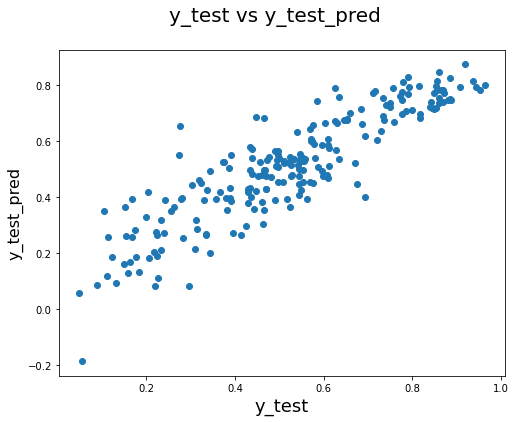

In [90]:
fig = plt.figure(figsize = (8,6))
plt.scatter(y_test, y_test_pred)
fig.suptitle('y_test vs y_test_pred', fontsize = 20)              
plt.xlabel('y_test', fontsize = 18)                         
plt.ylabel('y_test_pred', fontsize = 16)
plt.show()

We can see that the equation of our best fitted line is:

$ Totalcount = 0.2457  \times  year - 0.0883  \times  holiday - 0.1853 \times windspeed -0.2379 \times spring -0.0385 \times summer -0.1159 \times dec -0.1207 \times jan -0.1093 \times nov + 0.0595 \times sep - 0.0316 \times monday -0.0332 \times tuesday -0.3182 \times LightSnow -0.0884 \times MistCloudy $